# 1. Basic Usage

`TwoPopPy` employs the `simframe` framework for running scientific simulations. For a detailed description of the usage of `simframe` please have a look at the [Simframe Documentation](https://simframe.rtfd.io/).

This notebook demonstrates the basic steps of running a `TwoPopPy` simulation:
- Initializing and running the most simple (default) `TwoPopPy` model
- Plotting the data
- Resuming simulations from dump files

In [41]:
import numpy as np

## The Simulation Frame

To set up a model we have to import the `Simulation` class from the `TwoPopPy` package.

In [1]:
from tripod import Simulation

We can now create an instance of this class.

In [2]:
sim = Simulation()

At this stage `sim` is an empty simulation object that controls our simulation.

In [3]:
sim

DustPy
------
    dust         : Group (Dust quantities)
    gas          : Group (Gas quantities)
    grid         : Group (Grid quantities)
    star         : Group (Stellar quantities)
  -----
    t            : NoneType
  -----
    Integrator   : not specified
    Writer       : not specified

All the fields are initialized with `None`. All attributes can be easiliy addressed via e.g.

In [4]:
sim.gas

Group (Gas quantities)
----------------------
    boundary     : Group (Boundary conditions)
    S            : Group (Source terms)
    torque       : Group (Torque parameters)
    v            : Group (Velocities)
  -----
    alpha        : NoneType
    cs           : NoneType
    eta          : NoneType
    Fi           : NoneType
    Hp           : NoneType
    mfp          : NoneType
    mu           : NoneType
    n            : NoneType
    nu           : NoneType
    P            : NoneType
    rho          : NoneType
    Sigma        : NoneType
    SigmaFloor   : NoneType
    T            : NoneType
  -----

## Initializing

We can now initialize the `sim` object with `Simulation.initialize()`. `TwoPopPy` will then fill all the fields with default values.

In [5]:
sim.initialize()

As we can see, the `sim` object has now values assigned to its fields.  
**All quantities are in cgs units.**

In [6]:
sim.gas

Group (Gas quantities)
----------------------
    boundary     : Group (Boundary conditions)
    S            : Group (Source terms)
    torque       : Group (Torque parameters)
    v            : Group (Velocities)
  -----
    alpha        : Field (Turbulent alpha parameter)
    cs           : Field (Isothermal sound speed [cm/s])
    eta          : Field (Pressure gradient parameter)
    Fi           : Field (Gas flux interfaces [g/cm/s])
    Hp           : Field (Pressure scale height [cm])
    mfp          : Field (Midplane mean free path [cm])
    mu           : Field (Mean molecular weight [g])
    n            : Field (Miplane number density [1/cm³])
    nu           : Field (Kinematic viscosity [cm²/s])
    P            : Field (Midplane pressure [g/cm/s²])
    rho          : Field (Miplane mass density [g/cm³])
    Sigma        : Field (Surface density [g/cm²])
    SigmaFloor   : Field (Floor value of surface density [g/cm²])
    T            : Field (Temperature [K])
  -----

We can also display the full table of contents of the `sim` object.

In [7]:
sim.toc

DustPy
    - components: Group (components)
        - H2: Group (Molecular hydrogenH2 (dust_active=False, gas_active=True, gas_tracer=False))
            - boundary: Group (Boundary conditions for component)
                - inner: Value
                - outer: Value
            - dust: Group (Dust related fields)
                - S: Field (tracer source term [???/s])
                - S_Sigma: Field (Source term for dust surface density [g/cm²])
                - value: Field (tracer value [???])
            - gas: Group (Gas related fields)
                - Fi: Field (Gas flux [g/cm²/s])
                - pars: Group (Gas parameters)
                    - mu: Field (Mean molecular weight [g])
                    - nu: Field (trial frequency [1/s])
                    - Tsub: Field (evaporation temperatue [K])
                - S: Group (Gas source terms)
                    - ext: Field (External source term [g/cm²/s])
                    - hyd: Field (Hydrodynamical source term 

## Running a Simulation

The simulation is now ready to go. We can start it with ``Simulation.run()``. As the default simulation runs for 100,000 years, this will merely take a few moments.

In [8]:
sim.writer.overwrite = True

In [9]:
sim.run()


TriPoD v0.0.1

Writing file data/data0000.hdf5
Writing dump file data/frame.dmp
Writing file data/data0001.hdf5
Writing dump file data/frame.dmp
Writing file data/data0002.hdf5
Writing dump file data/frame.dmp
Writing file data/data0003.hdf5
Writing dump file data/frame.dmp
Writing file data/data0004.hdf5
Writing dump file data/frame.dmp
Writing file data/data0005.hdf5
Writing dump file data/frame.dmp
Writing file data/data0006.hdf5
Writing dump file data/frame.dmp
Writing file data/data0007.hdf5
Writing dump file data/frame.dmp
Writing file data/data0008.hdf5
Writing dump file data/frame.dmp
Writing file data/data0009.hdf5
Writing dump file data/frame.dmp
Writing file data/data0010.hdf5
Writing dump file data/frame.dmp
Writing file data/data0011.hdf5
Writing dump file data/frame.dmp
Writing file data/data0012.hdf5
Writing dump file data/frame.dmp
Writing file data/data0013.hdf5
Writing dump file data/frame.dmp
Writing file data/data0014.hdf5
Writing dump file data/frame.dmp
Writing f

By default, `TwoPopPy` has used the hdf5 writer to save output files to the `data/` directory.

## Plotting

`TwoPopPy` is coming with a simple plotting script that can be used to check the status of a simulation.

In [10]:
from tripod import plot

The plotting script does either take the simulation object as argument or a data directory.

If the argument is a simulation object the script is only plotting the current state.

(1, 100, 2)


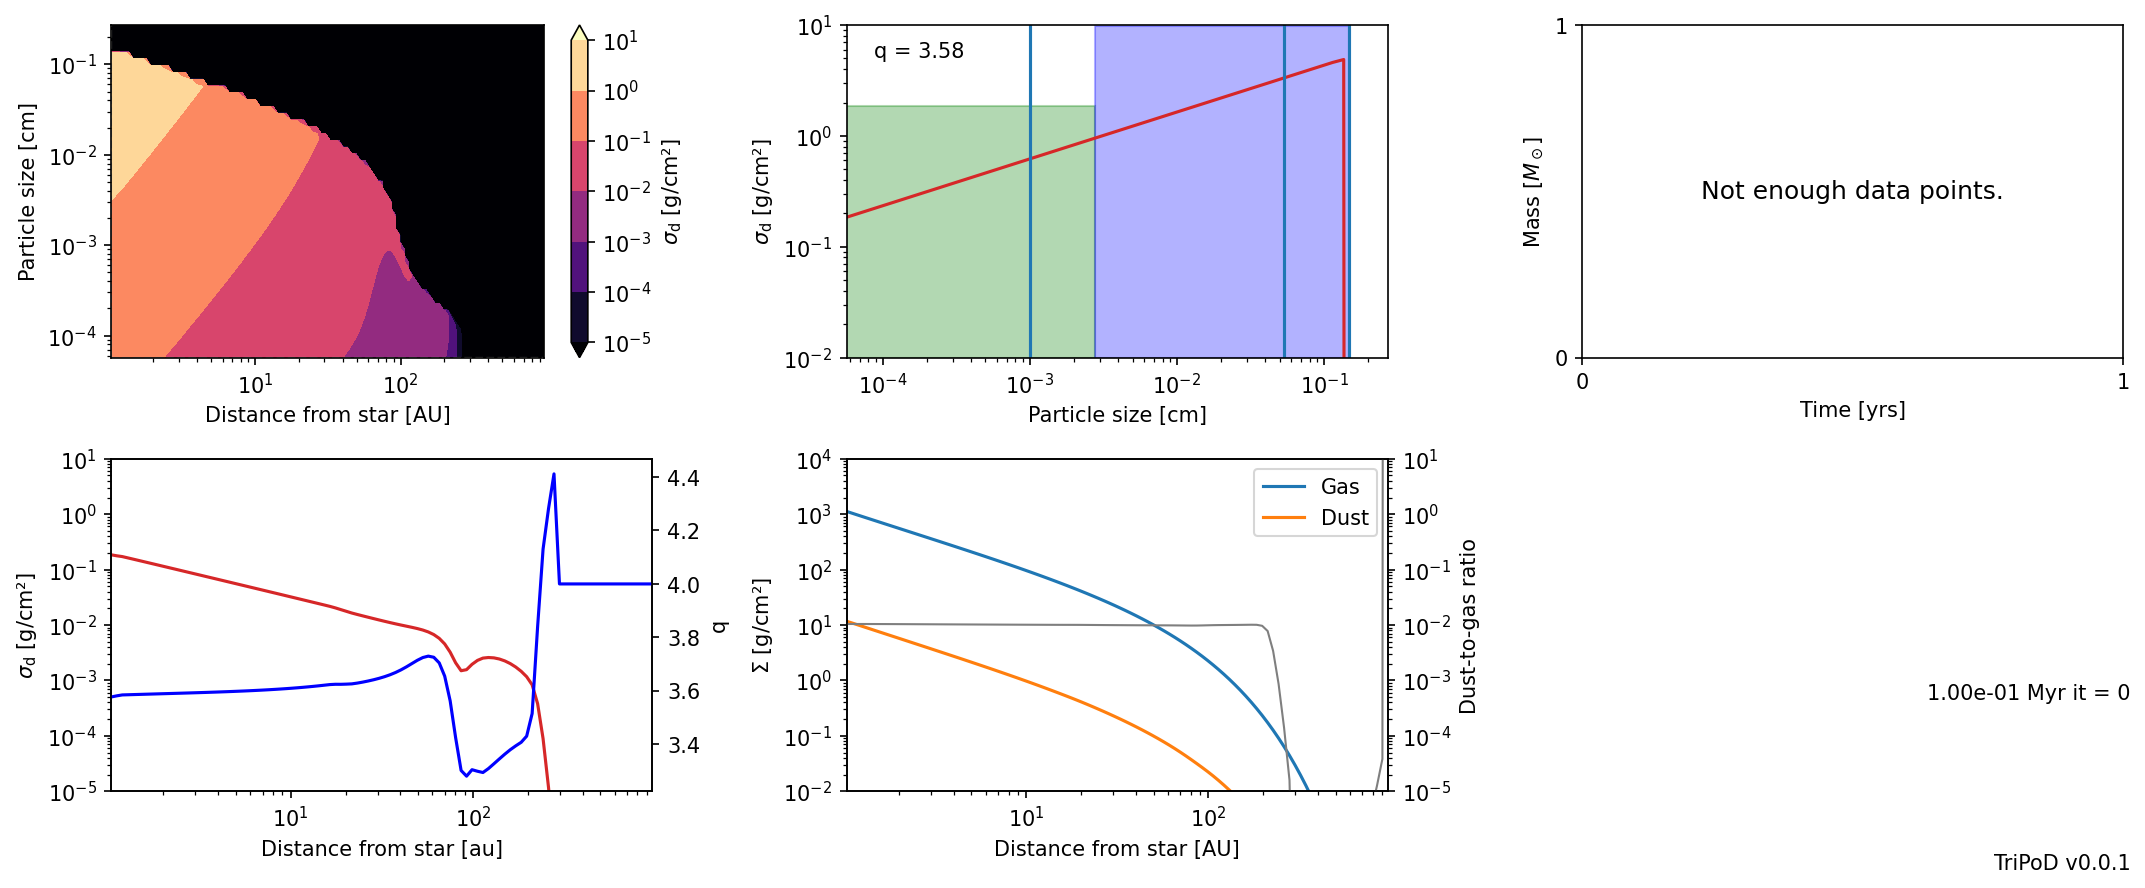

In [11]:
plot.panel(sim)

The blue and the green lines in the top left panel are analytical estimates for the fragmentation and drift barrier taken from [Birnstiel et al. (2012)](https://doi.org/10.1051/0004-6361/201118136).

If we pass the data directory as argument, we also have access to the time evolution.  
Furthermore, some plots can be addressed by specifying the time `it`, radial `ir`, or size `ia` index.

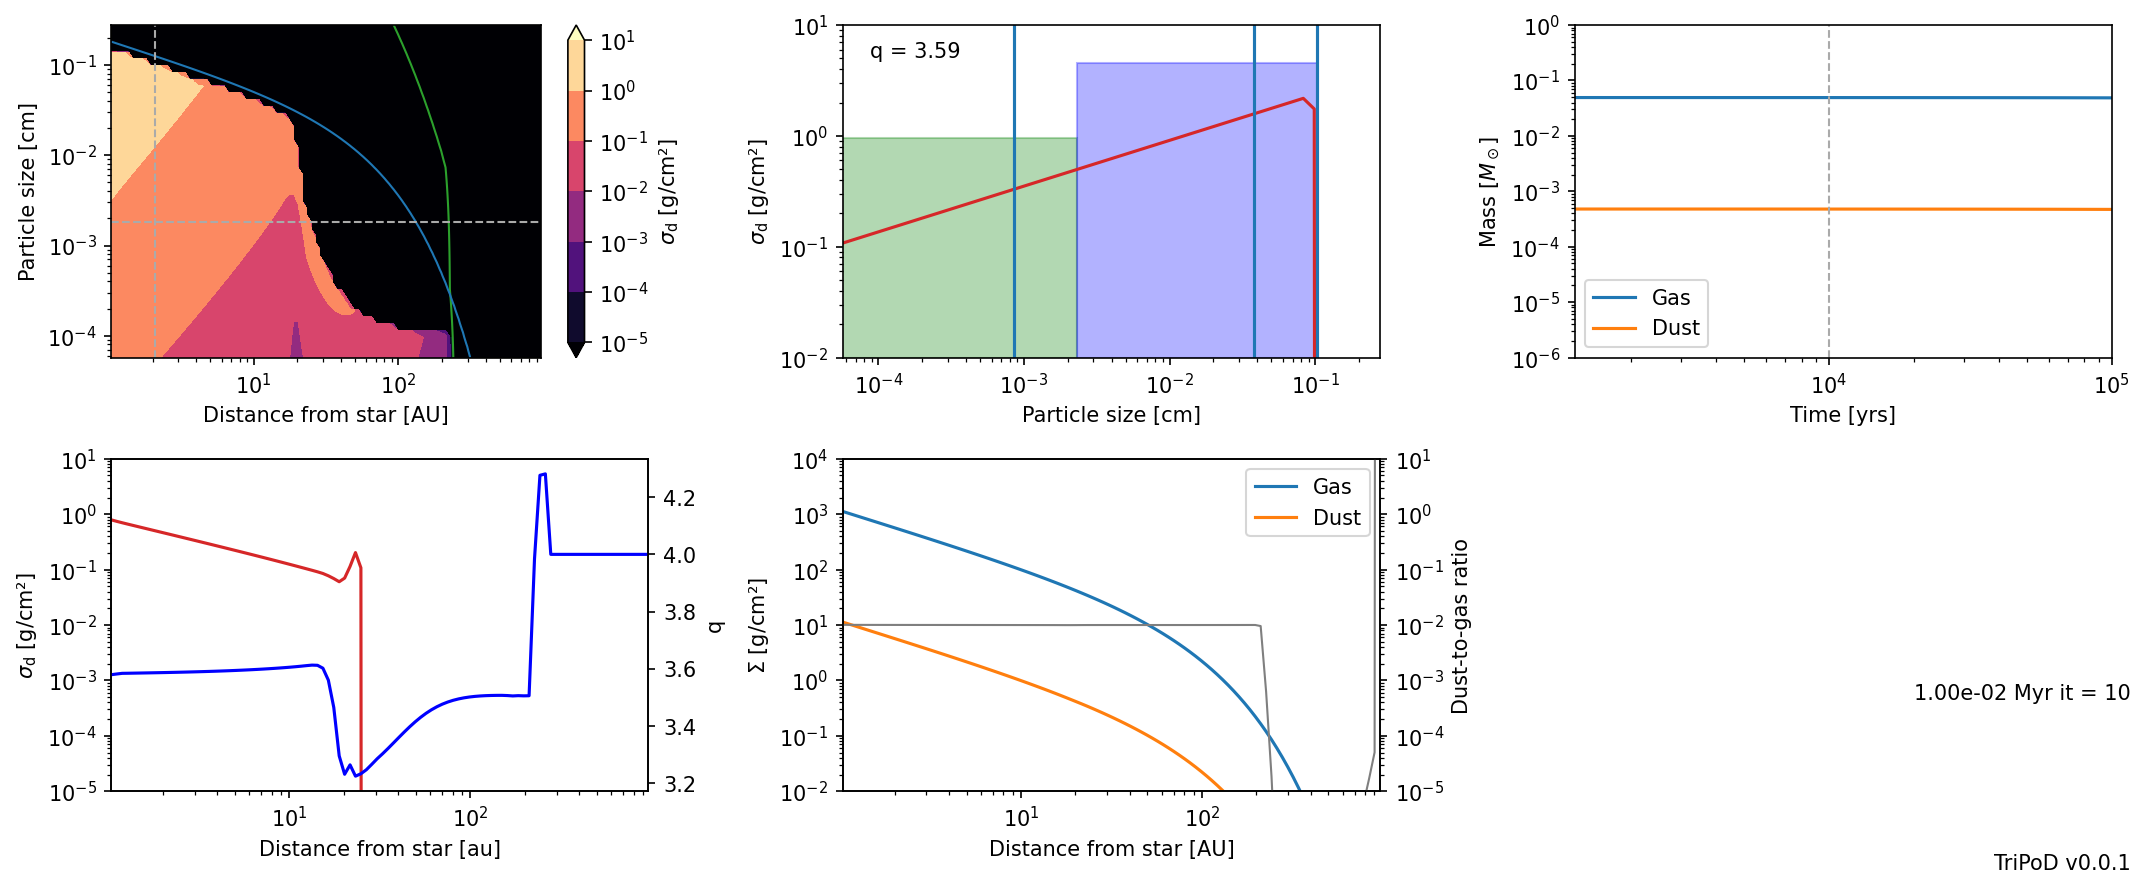

In [13]:
plot.panel("data", it=10, ir=10, ia=20,show_limits=True)

The top middle and bottom left panels show the dust density distribution along the gray dashed lines in the top left panel.

### Code Units
`TwoPopPy`simulates the evolution of the dust surface density in terms of the two population surface densities $\Sigma_0$ and $\Sigma_1$.

Together, they constitute the total dust density $\Sigma_{tot} = \int \limits_{m\left(s_{min}\right)}^{m\left(s_{max}\right)} \sigma\left(m\right) \mathrm{d}m = \int \limits_{m\left(s_{min}\right)}^{m\left(s_{int}\right)} \sigma\left(m\right) \mathrm{d}m + \int \limits_{m\left(s_{int}\right)}^{m\left(s_{max}\right)} \sigma\left(m\right) \mathrm{d}m = \Sigma_0 + \Sigma_1$.

In [14]:
SigmaTot = sim.dust.Sigma.sum(-1)
SigmaTot

[1.16684416e+01 1.08433976e+01 1.00701156e+01 9.35085240e+00
 8.68264165e+00 8.06202210e+00 7.48565661e+00 6.95041403e+00
 6.45336600e+00 5.99177778e+00 5.56309868e+00 5.16495242e+00
 4.79512758e+00 4.45156822e+00 4.13236472e+00 3.83574492e+00
 3.56006550e+00 3.30380380e+00 3.06554980e+00 2.84399861e+00
 2.63794321e+00 2.44626749e+00 2.26793972e+00 2.10200632e+00
 1.94758596e+00 1.80386407e+00 1.67008764e+00 1.54556043e+00
 1.42963848e+00 1.32172602e+00 1.22127167e+00 1.12776507e+00
 1.04073378e+00 9.59740625e-01 8.84381372e-01 8.14282798e-01
 7.49101162e-01 6.88521017e-01 6.32254256e-01 5.80038515e-01
 5.31626932e-01 4.86702470e-01 4.44840757e-01 4.05762183e-01
 3.69297807e-01 3.35451150e-01 3.04200100e-01 2.75379703e-01
 2.48812250e-01 2.24331148e-01 2.01788008e-01 1.81053952e-01
 1.62018092e-01 1.44575656e-01 1.28628491e-01 1.14080710e-01
 1.00835509e-01 8.87952903e-02 7.78661201e-02 6.79633998e-02
 5.90141280e-02 5.09563832e-02 4.37431081e-02 3.73549327e-02
 3.17842532e-02 2.695560

In order to display the data in a more granular way and compare it to dustpy outputs, we can use the distribution exponents $\xi$ to interpolate the dust surface density over a logarithmic mass grid. The density in the mass interval $\left[m_0, m_1\right]$ is then given by

$\Sigma_{[m_0, m_1]} = \int\limits_{m_0}^{m_1} \sigma\left(m\right) \mathrm{d}m = \Sigma_{tot} \frac{m_1^{\frac{\xi+4}{3}}-m_0^{\frac{\xi+4}{3}}}{m_{max}^{\frac{\xi+4}{3}}-m_{min}^{\frac{\xi+4}{3}}}$ for $\xi_{calc} \neq -4$ and $\Sigma_{tot} \frac{\log(m_1/m_0)}{\log(m_{max}/m_{min})}$ for $\xi_{calc} = -4$.

This calculation is automatically done in the data readout scheme of the plotting routine:

In [19]:
from tripod.utils import read_data
data = read_data("data")

The plotted dust density distribution is then given by

$\Sigma_\mathrm{d} = \int\limits_0^\infty \sigma \left(m \right) \mathrm{d} \log m$.

In this way the distribution is independent of the mass grid.

The code units `TwoPopPy` uses after interpolation of the dust density are $\Sigma_{\mathrm{d},\,i} \equiv \Sigma_\mathrm{d} \left(m_i \right)$ with

$\Sigma_\mathrm{d} = \sum\limits_i \Sigma_{\mathrm{d},\,i}$,

meaning the numerical sum over the mass dimension is the dust surface density.

In [26]:
data.dust.Sigma_recon.sum(-1)[-1,...]

array([1.16684416e+01, 1.08433976e+01, 1.00701156e+01, 9.35085240e+00,
       8.68264165e+00, 8.06202210e+00, 7.48565661e+00, 6.95041403e+00,
       6.45336600e+00, 5.99177778e+00, 5.56309868e+00, 5.16495242e+00,
       4.79512758e+00, 4.45156822e+00, 4.13236472e+00, 3.83574492e+00,
       3.56006550e+00, 3.30380380e+00, 3.06554980e+00, 2.84399861e+00,
       2.63794321e+00, 2.44626749e+00, 2.26793972e+00, 2.10200632e+00,
       1.94758596e+00, 1.80386407e+00, 1.67008764e+00, 1.54556043e+00,
       1.42963848e+00, 1.32172602e+00, 1.22127167e+00, 1.12776507e+00,
       1.04073378e+00, 9.59740625e-01, 8.84381372e-01, 8.14282798e-01,
       7.49101162e-01, 6.88521017e-01, 6.32254256e-01, 5.80038515e-01,
       5.31626932e-01, 4.86702470e-01, 4.44840757e-01, 4.05762183e-01,
       3.69297807e-01, 3.35451150e-01, 3.04200100e-01, 2.75379703e-01,
       2.48812250e-01, 2.24331148e-01, 2.01788008e-01, 1.81053952e-01,
       1.62018092e-01, 1.44575656e-01, 1.28628491e-01, 1.14080710e-01,
      

## Reading data files

If we want to read data files, we can use the read/writer module provided by `simframe` that is used to write the data.

In [27]:
from dustpy import hdf5writer

wrtr = hdf5writer()

We should make sure that the correct data directory is assigned to the writer.

In [28]:
wrtr

Writer (HDF5 file format using h5py)
------------------------------------
    Data directory : data
    File names     : data/data0000.hdf5
    Overwrite      : False
    Dumping        : True
    Options        : {'com': 'lzf', 'comopts': None}
    Verbosity      : 1

We can now read a single data file with

In [29]:
data0003 = wrtr.read.output(3)

This function returns a namespace and the data can simply be accessed in the same way as for the `Simulation` object.

In [30]:
data0003.gas.Sigma

array([1.11815368e+003, 1.04191907e+003, 9.70898855e+002, 9.04704294e+002,
       8.42981861e+002, 7.85410836e+002, 7.31699945e+002, 6.81583472e+002,
       6.34817484e+002, 5.91176644e+002, 5.50451809e+002, 5.12448290e+002,
       4.76984584e+002, 4.43891371e+002, 4.13010662e+002, 3.84195031e+002,
       3.57306912e+002, 3.32217934e+002, 3.08808315e+002, 2.86966287e+002,
       2.66587560e+002, 2.47574828e+002, 2.29837302e+002, 2.13290273e+002,
       1.97854715e+002, 1.83456897e+002, 1.70028039e+002, 1.57503977e+002,
       1.45824859e+002, 1.34934856e+002, 1.24781898e+002, 1.15317417e+002,
       1.06496121e+002, 9.82757728e+001, 9.06169847e+001, 8.34830310e+001,
       7.68396693e+001, 7.06549738e+001, 6.48991802e+001, 5.95445403e+001,
       5.45651853e+001, 4.99369988e+001, 4.56374965e+001, 4.16457144e+001,
       3.79421031e+001, 3.45084286e+001, 3.13276790e+001, 2.83839767e+001,
       2.56624953e+001, 2.31493814e+001, 2.08316806e+001, 1.86972674e+001,
       1.67347794e+001, 1

We can also read the entire data directory with

In [31]:
data = wrtr.read.all()

The data has now an additional dimension for time.

In [32]:
data.gas.Sigma.shape

(21, 100)

Data files can be quite large and reading the entire data set can consequently take some time. Instead, it is more efficient to only read single fields from the data files. We can do so via e.g.

In [33]:
SigmaGas = wrtr.read.sequence("gas.Sigma")

In [34]:
SigmaGas.shape

(21, 100)

It is also possible to exclude certain fields from being written into the data files to save memory by setting their `save` attribute to `False`.

In [36]:
sim.dust.v = False

## Reading Dump Files

The data files merely contain the pure data, but no information about the operations `TwoPopPy` has to perform, e.g. customized functions. Hence, it is not possible to directly restart a simulation from data files.

`simframe` is saving by default the most recent dump file, from which a simulation can be restarted.

**Attention:** Malware can be injected with dump files, which are pickled objects. One should only read dump files that were created by oneself or from trusted sources! Dump files have to be read with the same version of `TwoPopPy` as they were written. Otherwise, it is not guaranteed to work.

In [37]:
from dustpy import readdump

In [38]:
sim_restart = readdump("data/frame.dmp") 

This is now a simulation frame that should be identical to our previous object.

In [39]:
sim.gas.Sigma == sim_restart.gas.Sigma

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

We can now, for example, add more snapshots and restart the simulation. Here we just want to extend the run by one year.

In [42]:
from dustpy import constants as c

sim_restart.t.snapshots = np.concatenate((sim_restart.t.snapshots, [100001.*c.year]))

The current time is

In [43]:
sim_restart.t / c.year

100000.0

We can now restart the simulation for another year.

In [44]:
sim_restart.run()


TriPoD v0.0.1

Writing file data/data0021.hdf5
Writing dump file data/frame.dmp
Execution time: 0:00:00


Another file was written and the current time is now

In [45]:
sim_restart.t / c.year

100001.0